# Notícias G1 - 10. Classificação com Deep Learning LSTM

Será feita a classificação das notícias de categoria desconhecida com base no modelo Long Short Term Memory.



## Imports:

Importes de bibliotecas usadas com frequência no código.

In [360]:
import pandas as pd
import numpy as np

## Recuperando Dados Gravados:

Recuperando dados gravados após higienização, stemmer e stop words.

In [361]:
noticias = pd.read_csv('noticias_g1_higienizadas.csv')
print(noticias.shape)
noticias.head()

(3834, 5)


,titulo,url,texto,categoria,dado_tratado
0,Entenda como uma ampla coalizão tirou Netanyah...,https://g1.globo.com/mundo/noticia/2021/06/13/...,O Parlamento de Israel confirmou neste doming...,FALTANDO,"['entend', 'ampl', 'coaliz', 'tir', 'netanyahu..."
1,"Milionário de direita: quem é Naftali Bennett,...",https://g1.globo.com/mundo/noticia/2021/06/13/...,"Milionário do setor de tecnologia, Naftali Be...",FALTANDO,"['milion', 'direit', 'naftal', 'bennett', 'nov..."
2,Governo de SP antecipa datas de vacinação; vej...,https://g1.globo.com/sp/sao-paulo/noticia/2021...,O governo de São Paulo antecipou em 30 dias o...,FALTANDO,"['govern', 'sp', 'antecip', 'dat', 'vacin', 'v..."
3,PMs que mataram homens dentro de carro em SP s...,https://g1.globo.com/sp/sao-paulo/noticia/2021...,A Polícia Militar instaurou um inquérito poli...,FALTANDO,"['pm', 'mat', 'hom', 'dentr', 'carr', 'sp', 'a..."
4,"Após Venezuela e Bolívia, Colômbia confirma 2 ...",https://ge.globo.com/futebol/copa-america/noti...,A Federação Colombiana de Futebol informou ne...,diversos,"['após', 'venezuel', 'bolív', 'colômb', 'confi..."


## Separando Massa Conhecida e Desconhecida:

Parte dos dados dessa base está marcada na coluna "categoria" como "FALTANDO". Essa é a massa de dados que desejamos classificar após o treinamento do modelo. As demais linhas já contém uma categoria conhecida e vamos usar essa massa para treino e teste do modelo.

In [362]:
know_data = noticias[noticias.categoria != 'FALTANDO']
unknow_data = noticias[noticias.categoria == 'FALTANDO']
print("Dados separados: Massa conhecida={}, Massa desconhecida={}".format(know_data.shape, unknow_data.shape))

Dados separados: Massa conhecida=(1723, 5), Massa desconhecida=(2111, 5)


## Dicionário de Palavras:

A seguir iremos gerar o dicionário de palavras do problema conforme parâmetros abaixo:
* num_words é o tamanho máximo do dicionário de palavras.
* filters são filtros para remover caracteres especiais caso haja.
* lower transforma as palavras em caracteres minúsculos.

In [363]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=30000, filters='\'!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(noticias['dado_tratado'])
vocabulary = tokenizer.word_index

print('Found %s unique tokens.' % len(vocabulary))

Found 25432 unique tokens.


## Vetorização:

Precisamos vetorizar o texto de modo que seja transformado em uma sequencia de números inteiros que possa ser processado pela rede neural.

In [364]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_know = tokenizer.texts_to_sequences(know_data['dado_tratado'].values)
X_unknow = tokenizer.texts_to_sequences(unknow_data['dado_tratado'].values)

print('Resultado da vetorização:\n\n', X_know[4], '\n\n', X_unknow[4])

Resultado da vetorização:

 [637, 182, 1868, 3202, 64, 751, 637, 1080, 13000, 81, 110, 1, 334, 52, 46, 53, 5006, 1868, 3202, 307, 227, 1, 24, 1868, 526, 875, 326, 1922, 1094, 1373, 1951, 269, 73, 2314, 13001, 128, 3755, 3056, 1038, 11057, 63, 1481, 10, 751, 1, 186, 46, 230, 110, 203, 967, 13002, 1868, 567, 2417, 435, 824, 1808, 52, 768, 919, 230, 4229, 1868, 2950, 835, 3688, 27, 1719, 72, 2337, 1326, 186, 6060, 214, 103, 303, 1541, 82, 354, 261, 86, 361, 11058, 11059, 1161, 6061, 4567, 513, 11060, 722, 11061, 11062, 11063, 11064, 793, 11065, 722, 11066, 11067, 11068, 11069, 9750, 11070, 351, 2773, 93, 2096, 1646, 279, 11071, 586, 11072, 476, 709, 520, 1094, 1451, 28, 279, 1300, 722, 11073, 11074] 

 [3096, 3300, 2030, 48, 1125, 153, 4217, 6703, 3096, 3300, 2030, 48, 11, 286, 29, 9, 148, 1796, 1125, 3301, 5165, 1125, 4217, 6703, 1233, 596, 2112, 3096, 486, 4217, 6703, 26, 77, 44, 783, 148, 48, 106, 1125, 2093, 4698, 5784, 1196, 29, 1783, 943, 2175, 1807, 1784, 359, 845, 359, 1513, 2912,

## Padronizando Tamanho das Notícias

Vamos padronizar o tamanho das notícias truncando a partir de um número máximo de palavras e completando com zeros à esquerda nos casos em que a notícia não satisfizer esse máximo. Para tanto os seguintes parâmetros serão usados:

* padding: indica em que posição (antes ou depois do texto) será feito o complemento com zeros caso a notícia tenha menos que a quantidade de palavras esperada;

* truncating: indica em que posição (no início ou no final) o texto será truncado;

* maxlen: é o número máximo de palavras por notícia.

In [365]:
news_lenght = 250

X_know = pad_sequences(X_know, padding='post', truncating='post', maxlen=news_lenght)
X_unknow = pad_sequences(X_unknow, padding='post', truncating='post', maxlen=news_lenght)

print('Resultado da padronização:', X_know.shape, X_unknow.shape, '\n\n', X_know[4], '\n\n', X_unknow[4])

Resultado da padronização: (1723, 250) (2111, 250) 

 [  637   182  1868  3202    64   751   637  1080 13000    81   110     1
   334    52    46    53  5006  1868  3202   307   227     1    24  1868
   526   875   326  1922  1094  1373  1951   269    73  2314 13001   128
  3755  3056  1038 11057    63  1481    10   751     1   186    46   230
   110   203   967 13002  1868   567  2417   435   824  1808    52   768
   919   230  4229  1868  2950   835  3688    27  1719    72  2337  1326
   186  6060   214   103   303  1541    82   354   261    86   361 11058
 11059  1161  6061  4567   513 11060   722 11061 11062 11063 11064   793
 11065   722 11066 11067 11068 11069  9750 11070   351  2773    93  2096
  1646   279 11071   586 11072   476   709   520  1094  1451    28   279
  1300   722 11073 11074     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0    

## One Hot Encoder:

Como trata-se de um problema multiclasse vamos precisar utilizar a técnica one-hot-encoding. Nessa técnica é criada uma matriz onde cada classe torna-se uma coluna e, para cada registro, apenas a coluna da classe correta é sinalizada com valor 1, as demais colunas permanecem com zeros. 

O objetivo disso e tornar variáveis categóricas processáveis pela rede neural sem, contudo, utilizar ordem de grandeza pela atribuição de números inteiros - técnica conhecida como label enconding.

In [366]:
from sklearn.preprocessing import OneHotEncoder

def get_one_hot_encoder(array_data):
    np_data = pd.DataFrame(array_data).to_numpy()
    one_hot_encoder = OneHotEncoder(sparse=False)
    one_hot_encoder.fit(np_data)
    data_transformed = one_hot_encoder.transform(np_data)
    df_one_hot_encoder = pd.DataFrame(data_transformed)
    df_one_hot_encoder.columns = one_hot_encoder.categories_
    return one_hot_encoder.categories_[0], df_one_hot_encoder

categories, df_ohe_categories = get_one_hot_encoder(know_data['categoria'])
df_ohe_categories

,diversos,economia,educacao,politica,pop-arte,saude
0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
1718,0.0,1.0,0.0,0.0,0.0,0.0
1719,0.0,0.0,0.0,1.0,0.0,0.0
1720,1.0,0.0,0.0,0.0,0.0,0.0
1721,0.0,1.0,0.0,0.0,0.0,0.0


## Tratando Desbalanceamento das Classes:

Como as classes estão muito desbalanceadas faremos o tratamento desse problema por meio do ajuste dos pesos para cada categoria. Isso será feito usando o sklearn.

In [367]:
from sklearn.utils import class_weight

y_integers = np.argmax(df_ohe_categories.to_numpy(), axis=1)
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 28.716666666666665,
 1: 0.44315843621399176,
 2: 5.982638888888889,
 3: 0.5813090418353576,
 4: 0.8890608875128999,
 5: 1.4358333333333333}

## Divisão em Treino e Teste:

Vamos dividir a base de dados em massa para treino (70%) e massa para teste (30%).

In [368]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_know, df_ohe_categories, test_size=0.30, 
    random_state=33, stratify=know_data['categoria'])

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1206, 250) (517, 250) (1206, 6) (517, 6)


## LSTM - Configuração:

Configura a rede para classificação com LSTM.

In [369]:
import tensorflow as tf

# Setting Random Seeds:
random_seed = 33
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

model = tf.keras.Sequential([

    # Camada de entrada:
    tf.keras.layers.Embedding(input_dim=len(vocabulary), output_dim=128, input_length=news_lenght),
    
    # Camada Bidiretional com LSTM
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=32)),
    
    # Utilizando relu ao invés de tanh ganhamos performance:
    tf.keras.layers.Dense(32, activation='relu'),
    
    # Softmax converte a saida em probabilidade de distribuição:
    tf.keras.layers.Dense(categories.shape[0], activation='softmax')
])

model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 250, 128)          3255296   
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 64)                41216     
_________________________________________________________________
dense_26 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_27 (Dense)             (None, 6)                 198       
Total params: 3,298,790
Trainable params: 3,298,790
Non-trainable params: 0
_________________________________________________________________


## LSTM - Treinamento:

Realiza o treinamento para classificação com LSTM.

In [370]:
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

history = model.fit(
    pd.DataFrame(X_train),
    y_train,
    batch_size = 32,
    epochs = 50,
    class_weight = d_class_weights,
    validation_data = (pd.DataFrame(X_test), y_test), 
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=0.0001),
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, min_delta=0.0001)
    ],
    verbose = 2
)

Epoch 1/50
38/38 - 11s - loss: 0.1383 - accuracy: 0.4138 - val_loss: 0.1351 - val_accuracy: 0.4159
Epoch 2/50
38/38 - 7s - loss: 0.1147 - accuracy: 0.7695 - val_loss: 0.0700 - val_accuracy: 0.8607
Epoch 3/50
38/38 - 7s - loss: 0.0669 - accuracy: 0.9345 - val_loss: 0.0400 - val_accuracy: 0.9014
Epoch 4/50
38/38 - 7s - loss: 0.0411 - accuracy: 0.9735 - val_loss: 0.0366 - val_accuracy: 0.8743
Epoch 5/50
38/38 - 8s - loss: 0.0245 - accuracy: 0.9809 - val_loss: 0.0301 - val_accuracy: 0.8859
Epoch 6/50
38/38 - 7s - loss: 0.0119 - accuracy: 0.9818 - val_loss: 0.0304 - val_accuracy: 0.8859
Epoch 7/50
38/38 - 7s - loss: 0.0111 - accuracy: 0.9834 - val_loss: 0.0313 - val_accuracy: 0.8646
Epoch 8/50
38/38 - 7s - loss: 0.0029 - accuracy: 0.9892 - val_loss: 0.0280 - val_accuracy: 0.8936
Epoch 9/50
38/38 - 7s - loss: 0.0020 - accuracy: 0.9900 - val_loss: 0.0274 - val_accuracy: 0.8936
Epoch 10/50
38/38 - 8s - loss: 0.0016 - accuracy: 0.9909 - val_loss: 0.0268 - val_accuracy: 0.8956
Epoch 11/50
38/38 

In [382]:
model.save('noticias_g1_modelo_lstm.h5')

## Resultado do Treinamento:

Resultado apurado após o treinamento do modelo.

In [371]:
accr = model.evaluate(pd.DataFrame(X_test), y_test)
print(accr)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

17/17 [==============================] - 1s 36ms/step - loss: 0.0287 - accuracy: 0.9014
[0.028720391914248466, 0.9013539552688599]
Test set
  Loss: 0.029
  Accuracy: 0.901


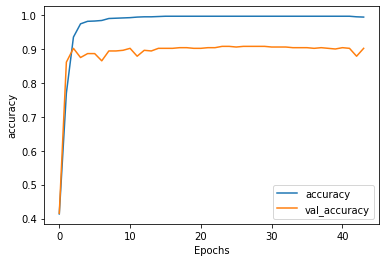

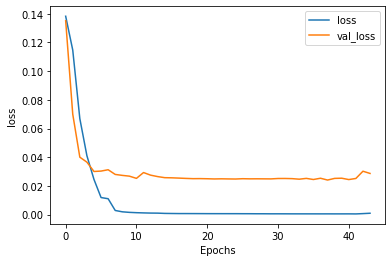

In [372]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Classificação da Massa de Teste:

Será realizado teste com a massa de dados separada para esse fim. Os resultados serão avaliados mais abaixo.

In [373]:
result = model.predict(pd.DataFrame(X_test))
classificacao_massa_teste = []
for pred in result:
    classificacao_massa_teste.append(categorys[np.argmax(pred)])
len(classificacao_massa_teste)

517

## Teste com Notícias Fictícias:

Teste com algumas notícias fictícias cujo contexto seja bastante claro.

In [374]:
def higienizar_texto (texto):
  import re
  texto = re.sub('[^a-zA-ZéúíóáÉÚÍÓÁèùìòàÈÙÌÒÀõãñÕÃÑêûîôâÊÛÎÔÂëÿüïöäËYÜÏÖÄçÇ\-\s]', '', texto)
  texto = re.sub('(\-..es)|(\-..e)|(\-.e)|(\-.os)|(\-ei)', '', texto)
  texto = re.sub('\-+', '', texto)
  return texto.lower()

import nltk
nltk.download('rslp')
from nltk.stem import RSLPStemmer
stemmer_ptbr = RSLPStemmer()

def apply_stem (text):
    return [stemmer_ptbr.stem(word) for word in text]

def classify_news(model, categories, news_lenght, news):
    higi = higienizar_texto(news)
    stemmed = apply_stem(higi.split())
    vectorized = tokenizer.texts_to_sequences([stemmed])
    padded = pad_sequences(vectorized, padding='post', truncating='post', maxlen=news_lenght)
    predic = model.predict(padded)[0]
    return predic, categories[np.argmax(predic)]

[nltk_data] Downloading package rslp to /Users/edprata/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [375]:
array_noticias = [
    'Exemplo de notícia inventada onde uma ação do governo causou instabilidade na bolsa e aumentou o dolar e o preço das mercadorias.',
    'Notícia em que as escolas foram fechadas, professores ficaram parados, meses sem aulas impactando nas vidas das familias, o ministério da educação nada faz.',
    'Os prefeitos não trataram adequadamente a crise e a população sofre as consequencias desse problema, os vereadores nada fazem, políticos não prestam',
    'Em Minas Gerais acontece grande show com presença de famosos mesmo em plena pandemia para divertir a multidão',
    'Um surto de gripe castiga a população do Rio Grande do Norte e os prefeitos buscam por alternativas'
]

for noticia in array_noticias:
    print(classify_news(model, categories, news_lenght, noticia)[1])

educacao
educacao
educacao
diversos
diversos


## Classificação da Base Desconhecida:

Classificação da massa de dados cuja categoria não conhecemos a partir do modelo treinado.

In [376]:
# Classificação:
classification = model.predict(X_unknow)

# Transformando índices em categorias legíveis:
result = []
for line in classification:
    result.append(categorys[np.argmax(line)])

classificacao_massa_desconhecida = result
np.unique(classificacao_massa_desconhecida)

array(['diversos', 'economia', 'educacao', 'politica', 'pop-arte',
       'saude'], dtype='<U8')

## Análise dos Resultados: Distribuição por Categoria:

Elabora gráficos para comparar a distribuição dos dados na massa de treino, de teste, e de classificação (cuja categoria é desconhecida).

In [377]:
# Array com labels das categorias da massade treino:
df_cat_treino_labels = []
for x in range(df_cat_treino.shape[0]):
    df_cat_treino_labels.append(np.argmax(df_cat_treino.iloc[x])[0])
print('Labels massa treino: ', len(df_cat_treino_labels))

# Array com labels das categorias da massa de teste:
df_cat_teste_labels = []
for x in range(0, df_cat_teste.index.size):
    df_cat_teste_labels.append(np.argmax(df_cat_teste.iloc[x])[0])
print('Labels massa teste: ', len(df_cat_teste_labels))

/Users/edprata/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:58: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return bound(*args, **kwds)


Labels massa treino:  1206
Labels massa teste:  517


In [378]:
# Calculando a distribuição:

from collections import Counter, OrderedDict

counter = sorted(Counter(df_cat_treino_labels).items(), key=lambda i: i[0])
dist_treino = pd.DataFrame(counter, columns=['cat', 'qtd'])

counter = sorted(Counter(df_cat_teste_labels).items(), key=lambda i: i[0])
dist_teste = pd.DataFrame(counter, columns=['cat', 'qtd'])

counter = sorted(Counter(classificacao_massa_teste).items(), key=lambda i: i[0])
dist_teste_ = pd.DataFrame(counter, columns=['cat', 'qtd'])

counter = sorted(Counter(classificacao_massa_desconhecida).items(), key=lambda i: i[0])
dist_classificacao = pd.DataFrame(counter, columns=['cat', 'qtd'])

print(dist_teste.shape, dist_teste_.shape, dist_classificacao.shape)

(6, 2) (6, 2) (6, 2)


/Users/edprata/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  if __name__ == '__main__':


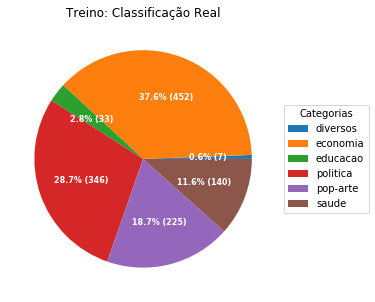

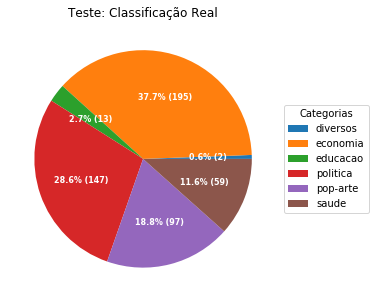

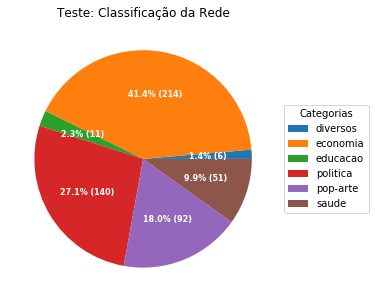

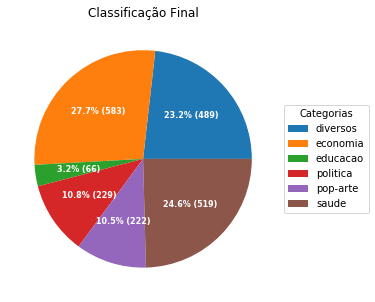

In [379]:
import matplotlib.pyplot as plt

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}% ({:d})".format(pct, absolute)

def pie(title, legend, data, label):
  fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(aspect="equal"))
  wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data), textprops=dict(color="w"))
  ax.legend(wedges, label, title=legend, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
  plt.setp(autotexts, size=8, weight="bold")
  ax.set_title(title)
  plt.show()

pie("Treino: Classificação Real", "Categorias", dist_treino[['qtd']], dist_teste['cat'])
pie("Teste: Classificação Real", "Categorias", dist_teste[['qtd']], dist_teste['cat'])
pie("Teste: Classificação da Rede", "Categorias", dist_teste_[['qtd']], dist_teste_['cat'])
pie("Classificação Final", "Categorias", dist_classificacao[['qtd']], dist_classificacao['cat'])

## Matrix de Confusão

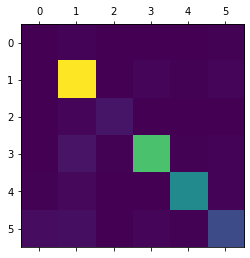

In [380]:
from sklearn.metrics import confusion_matrix
y_true = df_cat_teste_labels
y_pred = classificacao_massa_teste
matrix = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
df_matrix = pd.DataFrame(matrix, index=np.unique(y_true), columns=np.unique(y_true))
plt.matshow(df_matrix);

## Heat Map

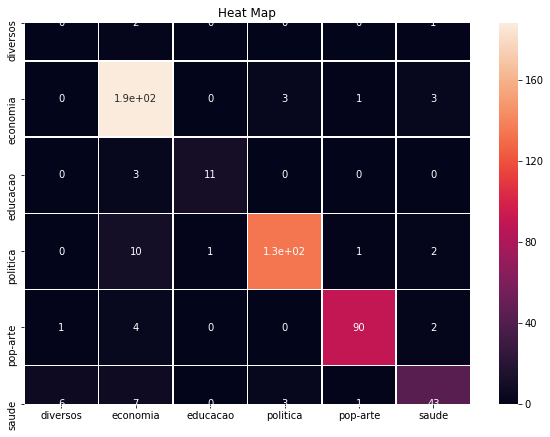

In [381]:
import seaborn as sn
plt.figure(figsize=(10,7))
plt.title("Heat Map")
sn.heatmap(df_matrix, annot=True, linewidths=.5, annot_kws={"size":10})